## Tinh chỉnh (hyperparameter tuning)

### Import thư viện

In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

### Load dữ liệu 

In [6]:
df_train = pd.read_excel("../exps/data/train_feat.xlsx")
df_valid = pd.read_excel("../exps/data/valid_feat.xlsx")
test = pd.read_excel("../exps/data/test_feat.xlsx")

### Xử lý dữ liệu trước khi train

In [7]:
# Loại bỏ cột không cần thiết
drop_cols = ["Ticket", "Cabin", "SibSp", "Parch"]
for col in drop_cols:
    if col in df_train.columns:
        df_train.drop(columns=col, inplace=True, errors="ignore")
        df_valid.drop(columns=col, inplace=True, errors="ignore")
        test.drop(columns=col, inplace=True, errors="ignore")

# Xử lý các cột phân loại (Label Encoding)
cat_cols = df_train.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    all_vals = pd.concat([df_train[col], df_valid[col], test[col]], axis=0).astype(str)
    le.fit(all_vals)

    df_train[col] = le.transform(df_train[col].astype(str))
    df_valid[col] = le.transform(df_valid[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

print("Hoàn tất xử lý dữ liệu trước train")
df_train.head()

Hoàn tất xử lý dữ liệu trước train


,Survived,Pclass,Sex,Age,Fare,Embarked,HasCabin,Deck,Title,FamilySize,IsAlone,AgeBin,FareBin
0,0,1,1,0.566474,0.055628,2,1,2,2,1,1,0,0
1,0,2,1,0.283740,0.025374,2,0,8,2,1,1,4,2
2,0,3,1,0.396833,0.015469,2,0,8,2,1,1,0,1
3,0,3,1,0.321438,0.015330,2,0,8,2,2,0,4,1
4,0,3,0,0.070118,0.061045,2,0,8,1,7,0,1,3


In [ ]:
# Chia features & target
X_train = df_train.drop("Survived", axis=1)
y_train = df_train["Survived"]

X_valid = df_valid.drop("Survived", axis=1)
y_valid = df_valid["Survived"]

print(f"Train: {X_train.shape}, Validation: {X_valid.shape}")

Train: (712, 12), Validation: (179, 12)


### Thiết lập RandomizedSearchCV (Dò thô)

In [9]:
param_dist = {
    'n_estimators': randint(100, 800),        # số lượng cây
    'learning_rate': uniform(0.01, 0.2),      # tốc độ học
    'max_depth': randint(3, 10),              # độ sâu của cây
    'min_samples_split': randint(2, 10),      # min mẫu để tách nút
    'min_samples_leaf': randint(1, 10),       # min mẫu tại lá
    'subsample': uniform(0.6, 0.4),           # tỉ lệ mẫu được lấy ngẫu nhiên cho mỗi cây
    'max_features': ['sqrt', 'log2', None]    # số lượng feature mỗi cây được xét
}

# Khởi tạo mô hình Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)

# Thiết lập RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Huấn luyện
random_search.fit(X_train, y_train)

print("Best parameters (Random Search):")
print(random_search.best_params_)
print(f"Best CV Accuracy: {random_search.best_score_:.4f}")

best_random_params = random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters (Random Search):
{'learning_rate': np.float64(0.042966852227400196), 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 323, 'subsample': np.float64(0.9941144202662018)}
Best CV Accuracy: 0.8371


### Fine-tuning quanh tham số tốt nhất

In [10]:
# Tạo lưới tham số tinh chỉnh quanh kết quả RandomizedSearchCV
param_grid_fine = {
    "max_depth": [
        max(1, best_random_params["max_depth"] - 1),
        best_random_params["max_depth"],
        best_random_params["max_depth"] + 1
    ],
    "learning_rate": [
        best_random_params["learning_rate"] * 0.8,
        best_random_params["learning_rate"],
        best_random_params["learning_rate"] * 1.2
    ],
    "subsample": [
        max(0.6, best_random_params["subsample"] - 0.1),
        best_random_params["subsample"],
        min(1.0, best_random_params["subsample"] + 0.1)
    ],
    "min_samples_split": [
        max(2, best_random_params["min_samples_split"] - 1),
        best_random_params["min_samples_split"],
        best_random_params["min_samples_split"] + 1
    ],
    "min_samples_leaf": [
        max(1, best_random_params["min_samples_leaf"] - 1),
        best_random_params["min_samples_leaf"],
        best_random_params["min_samples_leaf"] + 1
    ]
}

# Khởi tạo mô hình với tham số cơ bản từ best_random_params
fine_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=best_random_params["n_estimators"],
    max_features=best_random_params["max_features"]
)

# Tinh chỉnh bằng GridSearchCV
grid_search = GridSearchCV(
    estimator=fine_model,
    param_grid=param_grid_fine,
    scoring="accuracy",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Huấn luyện
grid_search.fit(X_train, y_train)

print("Best parameters (Fine-tuning):")
print(grid_search.best_params_)
print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")

best_params = grid_search.best_params_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters (Fine-tuning):
{'learning_rate': np.float64(0.051560222672880233), 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'subsample': 1.0}
Best CV Accuracy: 0.8385


### Thử nghiệm tham số

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import itertools

# Các giá trị muốn thử
param_grid = {
    "learning_rate": [0.05, 0.03],
    "max_depth": [3, 4, 5],
    "n_estimators": [300, 500, 700],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
}

# Duyệt mọi tổ hợp
best_acc = 0
best_params_combo = None

for combo in itertools.product(*param_grid.values()):
    params = dict(zip(param_grid.keys(), combo))
    
    model = GradientBoostingClassifier(
        **params,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    val_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, val_pred)
    
    if acc > best_acc:
        best_acc = acc
        best_params_combo = params
    
    print(f"{params} → {acc:.4f}")

print("\nBest Validation Accuracy:", round(best_acc, 4))
print("Best Params:", best_params_combo)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 1} → 0.8268
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8, 'min_samples_split': 2, 'min_samples_leaf': 2} → 0.8268
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 1} → 0.8268
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8, 'min_samples_split': 5, 'min_samples_leaf': 2} → 0.8212
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 1} → 0.8324
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0, 'min_samples_split': 2, 'min_samples_leaf': 2} → 0.8324
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0, 'min_samples_split': 5, 'min_samples_leaf': 1} → 0.8324
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators':

### Huấn luyện mô hình cuối cùng & đánh giá

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Mô hình Gradient Boosting tốt nhất từ quá trình tuning
final_model = GradientBoostingClassifier(
    learning_rate=0.03,
    max_depth=3,
    n_estimators=700,
    subsample=0.8,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

# Huấn luyện mô hình
final_model.fit(X_train, y_train)

# Dự đoán & đánh giá trên tập validation
y_pred = final_model.predict(X_valid)
val_acc = accuracy_score(y_valid, y_pred)

print(f"🏆 Final Validation Accuracy: {val_acc:.4f}")

🏆 Final Validation Accuracy: 0.8436


### Confusion Matrix cho final model

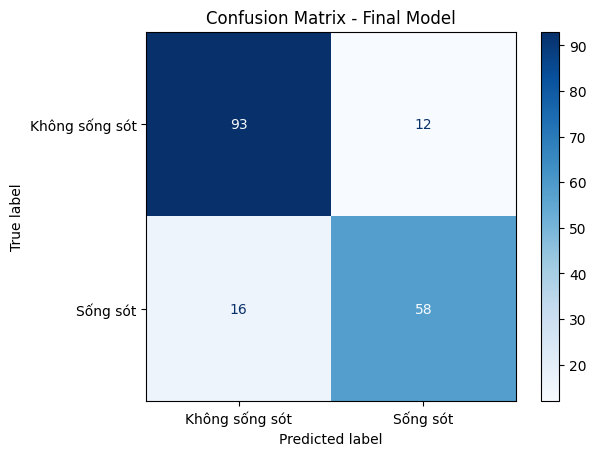

In [33]:
y_pred_val = final_model.predict(X_valid)

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_valid, y_pred_val)

# Vẽ confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Không sống sót", "Sống sót"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Final Model")
plt.show()

**Nhận xét**

Mô hình dự đoán khá tốt, khi nhận diện được 93/105 người không sống sót và 58/74 người sống sót. Tuy nhiên vẫn còn:
- 12 người bị dự đoán sai là sống sót (False Positive)
-  16 người bị dự đoán sai là không sống sót (False Negative)

=> Sai lệch này cho thấy mô hình hơi thiên về dự đoán "không sống sót"

In [34]:
import joblib
joblib.dump(final_model, "Gradient_Boosting_best_final.pkl")
print("Model saved as Gradient_Boosting_best_final.pkl")

Model saved as Gradient_Boosting_best_final.pkl


In [35]:
import pandas as pd

test_org = pd.read_csv("../../data/test.csv")

X_test = test.copy()

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

final_model = GradientBoostingClassifier(
    learning_rate=0.03,
    max_depth=3,
    n_estimators=700,
    subsample=0.8,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42
)

# Huấn luyện mô hình
final_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.03
,n_estimators,700
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [37]:
test_pred = final_model.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test_org["PassengerId"],
    "Survived": test_pred
})

submission.to_csv("submission.csv", index=False)
print("File submission.csv đã được tạo!")

File submission.csv đã được tạo!
